## Part 0 Set up

### Before you start this tutorial, you need have the following things done.
    
 1. Install R in you desktop.
    
       Type `R` in your terminal or powershell. 
       
       __If you enter R's interface, you are done!__
       
       R-3.3.1 for Mac OS: https://cran.r-project.org/bin/macosx/

       R-3.3.1 for Windows: https://cran.r-project.org/bin/windows/base/
        
        
 2. Install `numpy`, `matplotlib`, `pandas`.
 
 3. Install `networkX`.
 
 4. Install `sqlite3`.
 
 5. Install `rpy2`
 
 6. Most Important: have the database `data.sqlite` database in the current directory.

### This is a Data Visualizaition tutorial

We have all the inforamtion of the authors and documents from MISQ.

And we want to explore a relationship -- coauthorship. 

By the means of drawing the dynamic network graphs, we can find some insight of the authors' relationship and make good representation of the data we got.

## Part 1 Manipulate the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import networkx as nx

# itertools is used to make the combinations list between any two authors in one documents.
import itertools

# sqlite3 is used to query authors-documents data from data.sqlite
import sqlite3

In [3]:

# show the figures in the notebook
%matplotlib inline

__Here we use `sqlite3` and SQL language to query the data we want from the database.__


__Then use `pandas` to manipulate the tables.__

In [4]:
# make connection to the database
con = sqlite3.connect("data.sqlite")

# the SQL language, aim to get authors and their's documents information.
auth_docu_mod ='''
select authors_id, documents_id, full_name, title
from authors a, documents b, documents_authors c
where a.id=c.authors_id and c.documents_id=b.id;
'''

In [5]:
# in this way, we get the table we want to manipulated.
X = pd.read_sql(auth_docu_mod, con)
# this showsthe number of author-document relationship: 2757
print(len(X))

# this code will show the first 5 rows of the table.
X.head()

2757


,authors_id,documents_id,full_name,title
0,1,1,Gerald//Matlin,How to Survive a Management Assessment
1,2,2,A.//Jenkins,What the Information Analyst Should Know About...
2,3,2,Randall//Johnson,What the Information Analyst Should Know About...
3,4,3,Alfonso//Cardenas,Technology for the Automatic Generation of App...
4,5,4,Robert//Bostrom,MIS Problems and Failures: A Socio-Technical P...


In [6]:
# now we want a Series 
# whose index is documents' ids and 
# whose value is this document's authors number.
Documents = X.documents_id.groupby(by = X.documents_id).size()

# totally, we get 1287 documents.
print(len(Documents))

# show the first 3 values.
Documents.head(3)

1287


documents_id
1    1
2    2
3    1
dtype: int64

In [7]:
# this code is try to show the distribution of this Series
discribe = Documents.groupby(Documents).size().reset_index()
discribe

,index,0
0,1,353
1,2,537
2,3,299
3,4,76
4,5,13
5,6,6
6,7,2
7,14,1


__'index' is the one paper's authors number__

we can see:

the number of papers with 1 author is 353.

the number of papers with 2 author is 537.

...

there is just one paper whose authors number is 14 !

In [8]:
# the same logic can be applied in Authors


Authors = X.groupby(by = X.authors_id).size()
print(len(Authors))

Authors.head(3)

1685


authors_id
1    2
2    1
3    1
dtype: int64

In [9]:
discribe = Authors.groupby(Authors).size().reset_index()
discribe

,index,0
0,1,1255
1,2,216
2,3,104
3,4,42
4,5,23
5,6,14
6,7,7
7,8,4
8,9,4
9,10,5


There are 1255 authors who published 1 paper  in MISQ.

There are 216  authors who published 2 papers in MISQ.

There are a super star who published 30 papers in MISQ.

And, strikingly, there is an author who published 64 papers by himself.

But this author's name is "MIS Quarterly" (I don't know why)

In [10]:
# here I put all authors id in a set, for a further issue.
all_authors = set(X.authors_id)

# this show the total number of the authors: 1685
len(all_authors)

1685

## Part 2 Make Combination

In [11]:
# from this part, we start make combination between co-authors.

# here Y is an array, and the element is the unique document_ids of all documents
Y = X["documents_id"].unique()

x = []
y = {}

uniq = Y

len(Y)

1287

In [12]:
# this code make a dictionary y
# for every pair of key and value
# the key is the document_id
# the value is a Series whose elements are author_ids for the document that its key represents.

for article in uniq:
    y[article] = X.loc[X['documents_id'] == article]['authors_id']
    
len(y)

1287

__Here is a sample code shows how `itertools.combinations` work__

In [13]:
# first create a list
article = [ "auth1", "auth2", "auth3", "auth4"]

# then choose any two of them, the combinations' number is 2C4 = 6
# itertools.combinations() can do this job

g = itertools.combinations(article, 2)

# the type of g is generator, for some concerns, I will transfer it to a list.
print(type(g))
for i in g:
    print(i)

<class 'itertools.combinations'>
('auth1', 'auth2')
('auth1', 'auth3')
('auth1', 'auth4')
('auth2', 'auth3')
('auth2', 'auth4')
('auth3', 'auth4')


In [14]:
# create a list to contains all the combinations relationships.
combinations = []

for article in y:
    
    # here y[article] can be regarded as a list
    # I add list() here, to change generator to list.
    g = list(itertools.combinations(y[article], 2))
    
    for sub in g:
        combinations.append(sub)
        
# to show how many relationship we get.
len(combinations)


2243

In [15]:
# obviously, it is correct
5

5

## Part 3 Single Auth, Success Auth and Edges

__The aim is: Get Three Tables, and Used Them to Make Networks__

In [16]:
# here I divide the authors into two groups: success-authors and single-dogs (just a joke)
# the suc_authors are the authors who are in the list of combinations.
# the singlg_dogs are the authors who are not in the list of combinations

# to show in the networks graph
# suc_authors will have at least one edge to connect other authors
# single_dogs will just be the single dots in the graph.


suc_authors = set()
for edge in combinations:
    for auth in edge:
        suc_authors.add(auth)
        
single_dogs= all_authors - suc_authors

# the number of single dogs
print(len(single_dogs))
# the number of succes authors
print(len(suc_authors))

# something interesting I want to add
# intuitively, the authors who just have one paper published have great probablities to be single dogs
# however
# there are a lot of success authors just have one paper published, and
# there are also some single dogs who published 2, even 3 documents.

118
1567


In [17]:
# here I need to add the names as the labels.
# so I want to create a DataFrame A_N, author and name

A_N = X[['authors_id', 'full_name']]
A_N = A_N.drop_duplicates()
A_N.head()

,authors_id,full_name
0,1,Gerald//Matlin
1,2,A.//Jenkins
2,3,Randall//Johnson
3,4,Alfonso//Cardenas
4,5,Robert//Bostrom


In [18]:
# and I change the index to authors_ids in order to spare some trouble.
A_N.index = A_N.authors_id
A_N.head()

,authors_id,full_name
authors_id,,
1,1,Gerald//Matlin
2,2,A.//Jenkins
3,3,Randall//Johnson
4,4,Alfonso//Cardenas
5,5,Robert//Bostrom


In [19]:
# after we get author's name, then we should get authors' documents number

# then I split the table Authors to two sub-tables
# SA_paper_num: Single Author paper number
# SuA_paper_num: Succes Author paper number

SA_paper_num = Authors.ix[single_dogs]
SA_paper_num.head()

authors_id
1536    1
1       2
4       1
522     1
15      1
dtype: int64

In [20]:
# I must add this line to ignore those ugly pink warning boxes

from warnings import filterwarnings
filterwarnings('ignore') 

In [21]:
# these code is to combine authors' names and authors' papers' number together.

Single_Auth = A_N[A_N.authors_id.isin(single_dogs)]
Single_Auth["paper_num"] = SA_paper_num

Single_Auth.head()

,authors_id,full_name,paper_num
authors_id,,,
1,1,Gerald//Matlin,2
4,4,Alfonso//Cardenas,1
15,15,Peter//B.,1
19,19,C.W.//Getz,1
20,20,Hugh//Juergens,1


In [22]:
# the same logic is also applied to Success Authors

SuA_paper_num = Authors.ix[suc_authors]
SuA_paper_num.head()

Success_Auth = A_N[A_N.authors_id.isin(suc_authors)]
Success_Auth['paper_num'] = SuA_paper_num

Success_Auth.head()

,authors_id,full_name,paper_num
authors_id,,,
2,2,A.//Jenkins,1
3,3,Randall//Johnson,1
5,5,Robert//Bostrom,5
6,6,J.//Heinen,2
7,7,James//Johnson,1


Here, the table `Single_Auth` and `Success_Auth` can be regarded as the `nodes` in the NetworkX

__Next, we should get the `edges` from the list: `combinations`.__

In [23]:
# make the edges to Series
Edges = Series(combinations)

# for the depulicated edges, we want to get the frequency in the Series.
# therefore I need this code to make out a table with every unique Edge and its frequency.
Edges = Edges.groupby(Edges).size().reset_index()
Edges.rename(columns = {0: 'frequency', "index" : 'Edge'}, inplace = True)

# have a little view
Edges.head()


,Edge,frequency
0,"(2, 3)",1
1,"(5, 6)",2
2,"(5, 222)",2
3,"(5, 223)",2
4,"(7, 8)",1


## Part 4 Use Python's NetworkX

### 0 Introduction to NetworkX

Please refer networkx's docs: https://networkx.readthedocs.io/en/stable/

### Preface

We can think the network as a tree, the nodes (authors) in a same tree can be regarded in the same commuity.

For the whole authors from `misq` data, there are must be many trees, therefore many communities.

In a certain sense, communities may be independent to each others.

The size of the communities are different. Some communities just have one author, some have two, three, four authors, some may have hundreds authors.

It is necessary to separate them apart to each other by following some rules.

1. `First Blood`: the communities whose author number is one.

2. `Double Kill`: the communities whose author number is two.

3. `Triple Kill`: the communities whose author number is three.

4. `Quadra Kill`: the communities whose author number is four.

5. `Penta Kill`:  the communities whose author number is five or six.

6. `Rampage`:     the communities whose author number is seven or eight.

7. `Godlike`:     the communities whose author number is 10, 11, 12, 13

8. `Legendary`:   the communities whose author number is more than 700.



### 1 First Blood

In [24]:
# this shows how to index from DataFrame
a = Single_Auth.iloc[0]
print(a)
a.authors_id

authors_id                 1
full_name     Gerald//Matlin
paper_num                  2
Name: 1, dtype: object


1

In [25]:
# 1 with 118

# First Blood, is a collection of subgraphs whose node number is only 1
First_Blood = nx.Graph()

# from Single_Auth, add all the nodes to the big graph: First_Blood.
for i in range(len(Single_Auth)):
    a = Single_Auth.iloc[i]
    # note: I also add full_name and paper_num as the attributes to each node
    First_Blood.add_node(a.authors_id, full_name =a.full_name, paper_num = a.paper_num)
    


In [26]:
# then we want to classify different authors and draw them out in different styles

auth1 = [ auth for (auth, d) in First_Blood.nodes(data = True) if d["paper_num"] ==1]
auth2 = [ auth for (auth, d) in First_Blood.nodes(data = True) if d["paper_num"] ==2]
auth3 = [ auth for (auth, d) in First_Blood.nodes(data = True) if d["paper_num"] ==3]
auth4 = [ auth for (auth, d) in First_Blood.nodes(data = True) if d["paper_num"] >=4]

In [27]:
# to see the distribution
print(len(auth1))
print(len(auth2))
print(len(auth3))
print(len(auth4))


99
15
3
1


In [28]:
# let's generate a layout of this node number
pos = nx.random_layout(First_Blood)


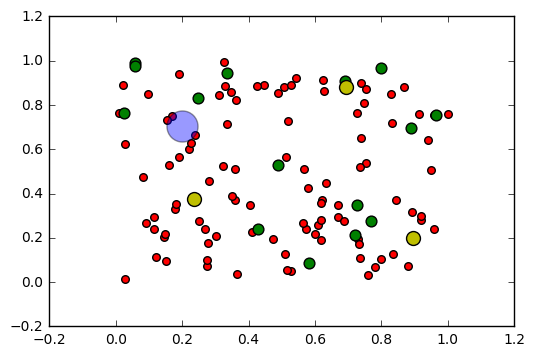

In [29]:
# now we can draw them out

# the authors who just have 1 paper
nx.draw_networkx_nodes(First_Blood,pos,nodelist = auth1, node_size=30)

# the authors who just have 2 papers, and assign its with the size: 60, color: green
nx.draw_networkx_nodes(First_Blood,pos,nodelist = auth2, node_size=60, node_color = 'g')
# the same logic
nx.draw_networkx_nodes(First_Blood,pos,nodelist = auth3, node_size=100, node_color = 'y')

# and an interesting node
nx.draw_networkx_nodes(First_Blood,pos,nodelist = auth4, node_size=500, node_color = 'b', alpha = 0.4, figsize = (100,400))


In [30]:
plt.savefig("graph.pdf")

### 2 More than First Blood

In [31]:
# now for the success authors
G = nx.Graph()

# base on the same logics

# add nodes from Success_Auth
for i in range(len(Success_Auth)):
    a = Success_Auth.iloc[i]
    G.add_node(a.authors_id, full_name =a.full_name, paper_num = a.paper_num)

# add nodes from Edges
for i in range(len(Edges)):
    edge = Edges.iloc[i]
    G.add_edge(edge.Edge[0], edge.Edge[1], freq = edge.frequency)

In [32]:
# Then we can generate the subgraphs
# G has many subgraphs
# a subgraphs consists of nodes which have edges between each
# the subgraphs are independent from each others.

# transfer the generator to list
subgraphs = list(nx.connected_component_subgraphs(G))

# get the length of the subgraphs
length = len(subgraphs)
length

294

In [33]:
# here I can group the subgraphs base on theirs nodes number
# I create a Series to record each subgraph's nodes number

subgraphs_size = Series()
for i in range(length):
    subgraphs_size.loc[i] = len(subgraphs[i].nodes())

# then I use this code to see the distribution of subgraphs' nodes number's distribution
discribe = subgraphs_size.groupby(subgraphs_size).size().reset_index()
discribe

,index,0
0,2,156
1,3,84
2,4,30
3,5,8
4,6,4
5,7,4
6,8,3
7,10,1
8,11,1
9,12,1


Each subgraphs can be regarded as a community.

156 subgraphs have 2 nodes

84 subgraphs have 3 nodes

30 subgraphs have 4 nodes

Interesting and strikingly,

There is a subgraph whose node number is 721, the biggest community in the database

In [34]:
# here I group them by their node number.

# 2 nodes
double_kill = [ subg for subg in subgraphs if len(subg.nodes()) == 2 ]

# 3 nodes
triple_kill = [ subg for subg in subgraphs if len(subg.nodes()) == 3 ]

# 4 nodes
quadra_kill = [ subg for subg in subgraphs if len(subg.nodes()) == 4 ]

# 5 - 6 nodes
penta_kill  = [ subg for subg in subgraphs 
               if len(subg.nodes()) == 5  or len(subg.nodes()) == 6 ]

# 7 - 8 nodes (no 9 nodes)
rampage     = [ subg for subg in subgraphs 
               if len(subg.nodes()) == 7  or len(subg.nodes()) == 8 ]

# 10, 11, 12, 13 nodes
godlike     = [ subg for subg in subgraphs 
               if len(subg.nodes()) >= 10 and len(subg.nodes()) < 14]


# 721 biggest nodes              
legendary   = [ subg for subg in subgraphs
               if len(subg.nodes()) >= 14 ]

In [35]:
# initialize them from nx.Graph()
Double_Kill = nx.Graph()
for subg in double_kill:
    Double_Kill.add_edges_from(subg.edges(data = True))
    Double_Kill.add_nodes_from(subg.nodes(data = True))
                   

Triple_Kill = nx.Graph()
for subg in triple_kill:
    Triple_Kill.add_edges_from(subg.edges(data = True))
    Triple_Kill.add_nodes_from(subg.nodes(data = True))

Quadra_Kill = nx.Graph()
for subg in quadra_kill:
    Quadra_Kill.add_edges_from(subg.edges(data = True))
    Quadra_Kill.add_nodes_from(subg.nodes(data = True))

Penta_Kill = nx.Graph()
for subg in penta_kill:
    Penta_Kill.add_edges_from(subg.edges(data = True))
    Penta_Kill.add_nodes_from(subg.nodes(data = True))

Rampage = nx.Graph()
for subg in rampage:
    Rampage.add_edges_from(subg.edges(data = True))
    Rampage.add_nodes_from(subg.nodes(data = True))

Godlike = nx.Graph()
for subg in godlike:
    Godlike.add_edges_from(subg.edges(data = True))
    Godlike.add_nodes_from(subg.nodes(data = True))

Legendary = nx.Graph()
for subg in legendary:
    Legendary.add_edges_from(subg.edges(data = True))
    Legendary.add_nodes_from(subg.nodes(data = True))


__Then follow the same logic, we can define a function to do this job__


In [36]:
# create a function to draw them out.



# Achievement are:
# First_Blood
# Double_Kill
# Triple_Kill
# ...
# Legendary

# layout are:
# "random"
# "spring"
# "spectral"
# "shell"

def DrawGraph(Achievement, layout = "random"):
    # choose a layout of graph
    if layout == "random":
        pos = nx.random_layout(Achievement)
    if layout == "shell":
        pos = nx.shell_layout(Achievement)
    if layout == "spring":
        pos = nx.spring_layout(Achievement)
    if layout == "spectral":
        pos = nx.spectral_layout(Achievement)
    
    # for nodes
    
    # classify the authors base on their document number
    auth1 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] ==1]
    auth2 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] ==2]
    auth3 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] ==3]
    auth4 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] ==4]
    
    
    auth5_10  = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] >=5  and d["paper_num"] < 11 ]
    auth11_20 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] >=11 and d["paper_num"] < 21 ]  
    auth21_30 = [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] >=21 and d["paper_num"] < 31 ]
    
    auth31_   =  [ auth for (auth, d) in Achievement.nodes(data = True) if d["paper_num"] >=31]
    
    
    # draw these author nodes
    
    # here we can change the nodes' size and color and transparent degree by parameter: alpha
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth1, node_size=60)
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth2, node_size=130, node_color = 'g')
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth3, node_size=150, node_color = 'y')
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth4, node_size=200, node_color = 'b')
    
    
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth5_10,  node_size=400, node_color = 'c',alpha = 0.7)
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth11_20, node_size=500, node_color = 'm',alpha = 0.8)
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth21_30, node_size=800, node_color = 'k',alpha = 0.9)
    
    nx.draw_networkx_nodes(Achievement,pos,nodelist = auth31_, node_size=1000, node_color = 'r', alpha = 0.5)
    
    
    # for edges
    
    # classify the edges based on their freqs
    edge1 = [ (u,v) for (u,v,d) in Achievement.edges(data = True) if d["freq"] == 1]
    edge2 = [ (u,v) for (u,v,d) in Achievement.edges(data = True) if d["freq"] == 2]
    edge3 = [ (u,v) for (u,v,d) in Achievement.edges(data = True) if d["freq"] == 3]
    
    
    # here we can change the nodes' size and color and width and transparent degree.
    nx.draw_networkx_edges(Achievement, pos, edgelist = edge1, width = 1, edge_color = "grey")
    nx.draw_networkx_edges(Achievement, pos, edgelist = edge2, width = 5,  edge_color = 'b',alpha = 0.8)
    nx.draw_networkx_edges(Achievement, pos, edgelist = edge3, width = 7, edge_color = "m",alpha = 0.7)

    # for labels
    names = {}
    for v, d in Achievement.nodes(data = True):
        names[v] = d["full_name"]
    nx.draw_networkx_labels(Achievement,pos,names,font_size=2, color ="b")



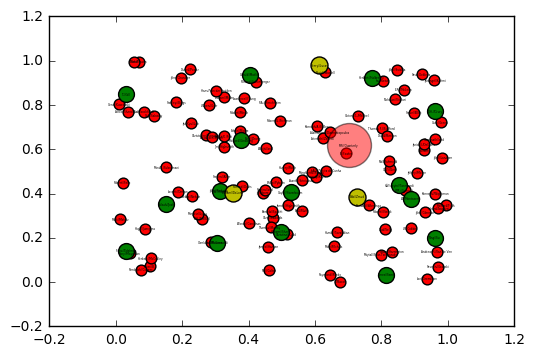

In [37]:
DrawGraph(First_Blood)

In [38]:
plt.close()

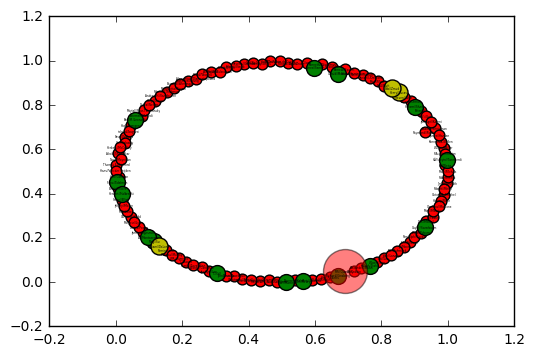

In [39]:
DrawGraph(First_Blood, layout = "spring")

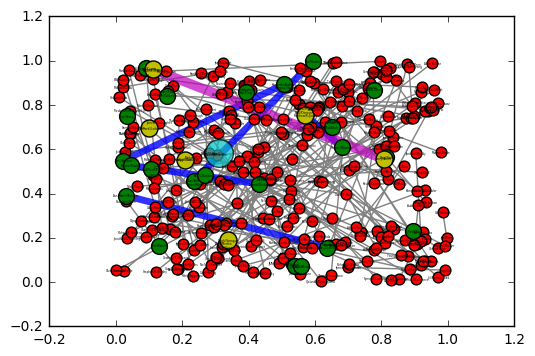

In [40]:
DrawGraph(Double_Kill)

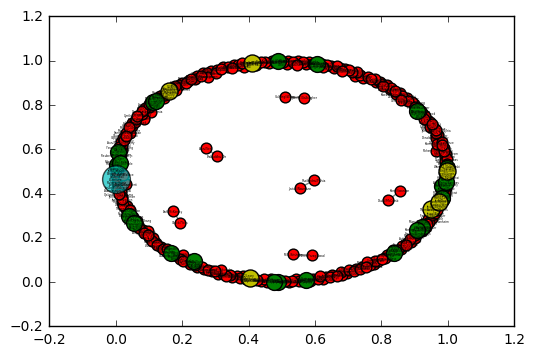

In [41]:
DrawGraph(Double_Kill, layout = "spring")

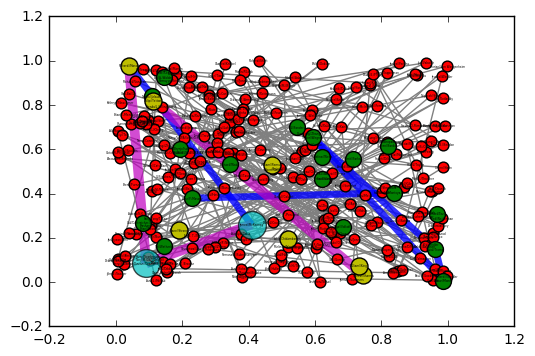

In [42]:
DrawGraph(Triple_Kill)

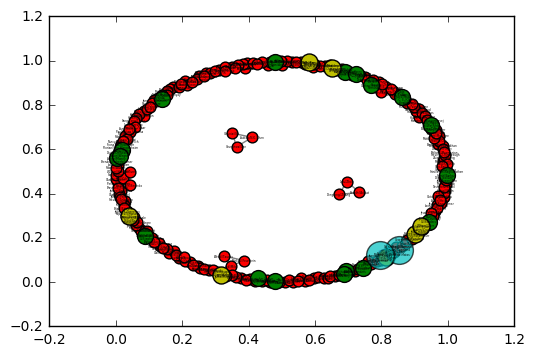

In [43]:
DrawGraph(Triple_Kill, layout = "spring")

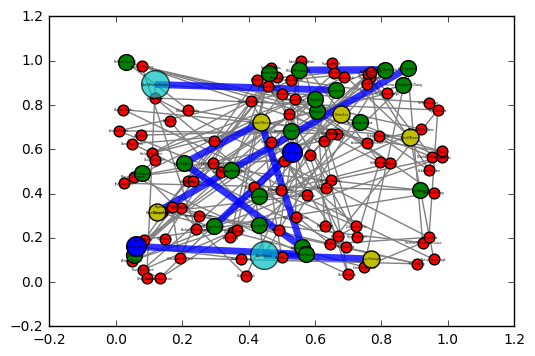

In [44]:
DrawGraph(Quadra_Kill)

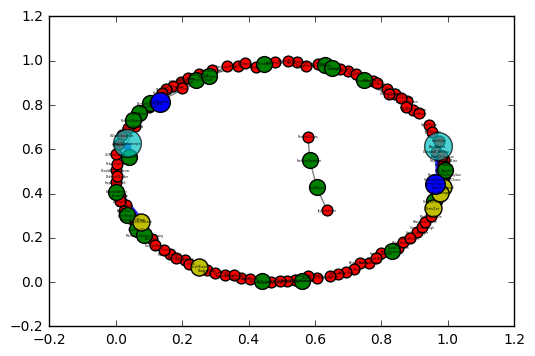

In [45]:
DrawGraph(Quadra_Kill, layout = "spring")

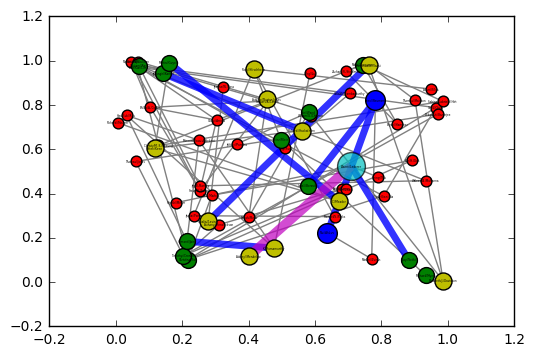

In [46]:
DrawGraph(Penta_Kill)

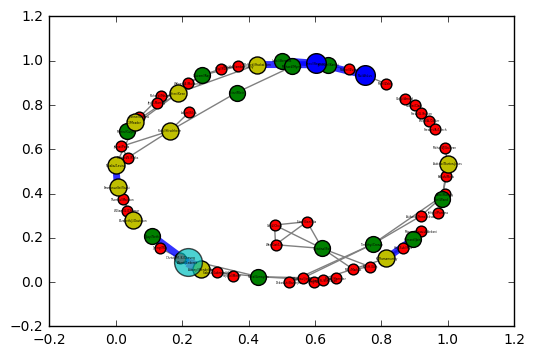

In [47]:
DrawGraph(Penta_Kill, layout = "spring")

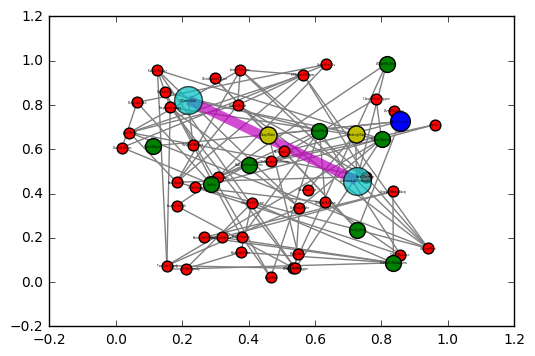

In [48]:
DrawGraph(Rampage)

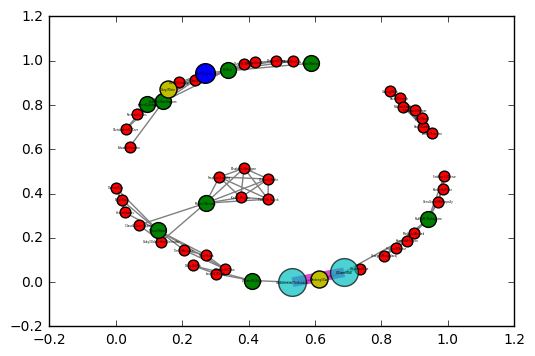

In [49]:
DrawGraph(Rampage, layout = "spring")


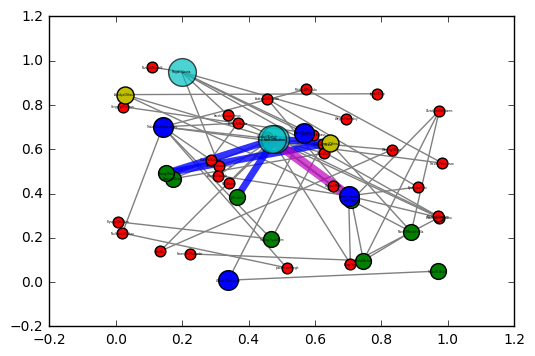

In [50]:
DrawGraph(Godlike)

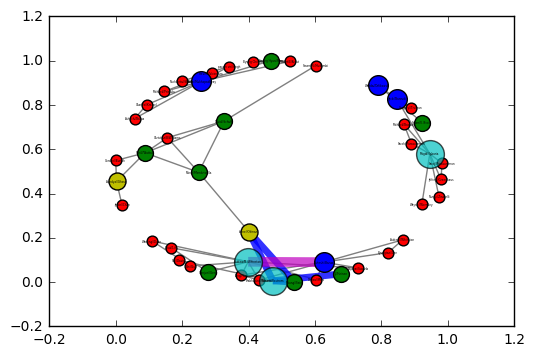

In [51]:
DrawGraph(Godlike, layout = "spring")

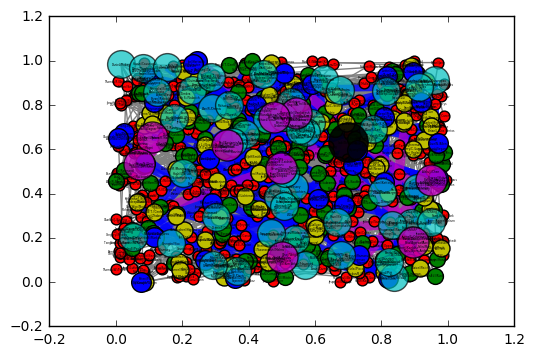

In [52]:
DrawGraph(Legendary)

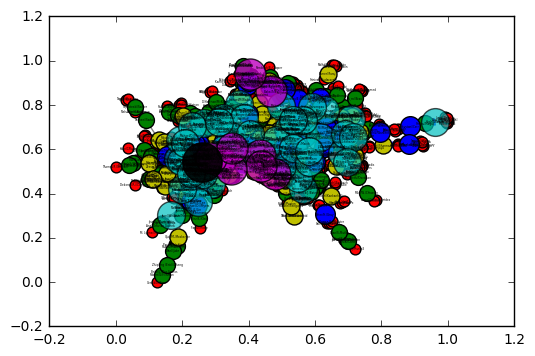

In [53]:
DrawGraph(Legendary, layout = "spring")

## Part 5 Use R's NetworkD3

__Obviously, the graphs we got were in mess__

Even thought significant improvements can be achieved, I turned to `networkd3` now. 

This is a R package.

In [54]:
# import "importr", which means import R.
from rpy2.robjects.packages import importr

# import R object
import rpy2.robjects as ro

# import the tool to change Data Frame to R's data.frame
from rpy2.robjects import pandas2ri
pandas2ri.activate()

### Take the Legendary as an example

In [55]:
# load the Links data from Legendary to Data Frame

Links = pd.DataFrame(data=Legendary.edges(data = True))
Links.head()

,0,1,2
0,7,8,{'freq': 1}
1,7,9,{'freq': 1}
2,8,84,{'freq': 1}
3,8,9,{'freq': 1}
4,8,439,{'freq': 1}


__Notice that the elements in the third column are dictionaries.__

__We have to change its form__

In [56]:
# just in this way

freq = Series([edge['freq'] for edge in Links[2]])
Links['freq'] = freq
len(freq)

1294

In [57]:
Links.head()


,0,1,2,freq
0,7,8,{'freq': 1},1
1,7,9,{'freq': 1},1
2,8,84,{'freq': 1},1
3,8,9,{'freq': 1},1
4,8,439,{'freq': 1},1


__Now the column `freq` is cumbersome, why not delete it?__

In [58]:
del Links[2]
Links.head()

,0,1,freq
0,7,8,1
1,7,9,1
2,8,84,1
3,8,9,1
4,8,439,1


__The same logic for Nodes__

In [59]:
Nodes = pd.DataFrame(data=Legendary.nodes(data = True))
Nodes.head()

,0,1
0,7,"{'paper_num': 1, 'full_name': 'James//Johnson'}"
1,8,"{'paper_num': 7, 'full_name': 'Kenneth//Kozar'}"
2,9,"{'paper_num': 1, 'full_name': 'David//Ruch'}"
3,21,"{'paper_num': 2, 'full_name': 'James//Danziger'}"
4,22,"{'paper_num': 3, 'full_name': 'Malcom//Munro'}"


In [60]:
Nodes[1][0]

{'full_name': 'James//Johnson', 'paper_num': 1}

In [61]:
paper_num = Series([auth['paper_num'] for auth in Nodes[1]])
print(len(paper_num))

721


In [62]:
full_name = Series([auth['full_name'] for auth in Nodes[1]])
print(len(full_name))

721


In [63]:
Nodes['paper_num'] = paper_num
Nodes['full_name'] = full_name


In [64]:
Nodes.head()

,0,1,paper_num,full_name
0,7,"{'paper_num': 1, 'full_name': 'James//Johnson'}",1,James//Johnson
1,8,"{'paper_num': 7, 'full_name': 'Kenneth//Kozar'}",7,Kenneth//Kozar
2,9,"{'paper_num': 1, 'full_name': 'David//Ruch'}",1,David//Ruch
3,21,"{'paper_num': 2, 'full_name': 'James//Danziger'}",2,James//Danziger
4,22,"{'paper_num': 3, 'full_name': 'Malcom//Munro'}",3,Malcom//Munro


In [65]:
del Nodes[1]
Nodes.head()

,0,paper_num,full_name
0,7,1,James//Johnson
1,8,7,Kenneth//Kozar
2,9,1,David//Ruch
3,21,2,James//Danziger
4,22,3,Malcom//Munro


### Here is the Nodes and Links we have

In [66]:
Nodes.head()

,0,paper_num,full_name
0,7,1,James//Johnson
1,8,7,Kenneth//Kozar
2,9,1,David//Ruch
3,21,2,James//Danziger
4,22,3,Malcom//Munro


In [67]:
Links.head()

,0,1,freq
0,7,8,1
1,7,9,1
2,8,84,1
3,8,9,1
4,8,439,1


### A big problem to solve

__Notice our author's label is a series of number__

__This series of number is not as 0, 1, 2, 3, .....__

__But in the form as 7, 8, 9, 13....__

__However, this thing matters__.


__Error raised in Rstudio__




![screen shot 2016-10-02 at 11 09 49 pm](https://cloud.githubusercontent.com/assets/18824134/19021538/9bd5b79c-88f6-11e6-8808-f70462875ec6.png)


Here my label is not as the form of 1, 2, 3, 4...

![screen shot 2016-10-02 at 11 09 38 pm](https://cloud.githubusercontent.com/assets/18824134/19021539/9d8058b8-88f6-11e6-82b0-749f49c8e4c9.png)

Error raised

### Change to the Required Form

In [68]:
l = list(Nodes[0])
def sort(a):
    return l.index(a)

In [69]:
sort(439)

132

In [70]:
sort2 = lambda a: l.index(a)
sort2(439)

132

In [71]:
Nodes[0] = Nodes[0].map(sort)

In [72]:
# by this way, the problem is solved 

Links[0] = Links[0].map(sort)
Links[1] = Links[1].map(sort)
Links.head()

,0,1,freq
0,0,1,1
1,0,2,1
2,1,28,1
3,1,2,1
4,1,132,1


### Enter R language

In [73]:
# transfer to the r object
Links_r = pandas2ri.py2ri(Links)

In [74]:
# make the object: source, target
ro.globalenv['source'] = Links_r[0]
ro.globalenv['target'] = Links_r[1]

# the index must be the integers
ro.globalenv['freq'] = Links_r[2]

ro.r('Links=data.frame(source,target,freq)')

,source,target,freq
1,0,1,1
2,0,2,1
3,1,28,1
4,1,2,1
5,1,132,1
6,1,109,1
7,1,130,1
8,1,66,1
9,1,52,1
10,3,100,1


In [75]:
# this is the same logic for Nodes
Nodes_r = pandas2ri.py2ri(Nodes)
ro.globalenv['author_id'] = Nodes_r[0]
ro.globalenv['num'] = Nodes_r[1]

# the index must be the integers
ro.globalenv['name'] = Nodes_r[2]

ro.r('Nodes=data.frame(author_id,num,name)')


,author_id,num,name
1,0,1,James//Johnson
2,1,7,Kenneth//Kozar
3,2,1,David//Ruch
4,3,2,James//Danziger
5,4,3,Malcom//Munro
6,5,5,Gordon//Davis
7,6,8,Gerardine//DeSanctis
8,7,1,Charles//Franz
9,8,7,Daniel//Robey
10,9,1,Robert//Koeblitz


In [76]:
# import R's library
utils = importr('utils')
networkD3 = importr('networkD3')
magrittr = importr('magrittr')

In [77]:
# have a look at our data.fram object
ro.r("Nodes[1:5,]")

,author_id,num,name
1,0,1,James//Johnson
2,1,7,Kenneth//Kozar
3,2,1,David//Ruch
4,3,2,James//Danziger
5,4,3,Malcom//Munro


In [78]:
ro.r("Links[1:5,]")

,source,target,freq
1,0,1,1
2,0,2,1
3,1,28,1
4,1,2,1
5,1,132,1


In [79]:
# write the R command 
# here the configuration can be set.
R_command = '''
a = forceNetwork(Links = Links, 
             Nodes = Nodes, 
             Source = "source",
             Target = "target", 
             Value = "freq", 
             NodeID = "name",
             Nodesize = "num",
             Group = "num", 
             opacity = 0.9, 
             zoom = TRUE,
             legend = TRUE,
             fontSize = 15,
             bounded = TRUE,
             charge = -30,
             linkWidth = JS("function(d) { return d.value*d.value; }"),
             linkDistance = 40,
             radiusCalculation = JS("3* Math.sqrt(d.nodesize) +5 "))
             '''

__For more specific description of the function `forceNetwork`, please have a check in the MarkDown file: `forceNetwork.md` in this repository__

In [80]:
ro.r(R_command)

R object with classes: ('forceNetwork', 'htmlwidget') mapped to:
<ListVector - Python:0x1181ddfc8 / R:0x11d274470>
[ListV..., RNULL..., RNULL..., ..., RNULL..., RNULL..., ListV...]
R object with classes: ('forceNetwork', 'htmlwidget') mapped to:
<ListVector - Python:0x1181ddfc8 / R:0x11d274470>
[ListV..., RNULL..., RNULL..., ..., RNULL..., RNULL..., ListV...]
  width: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  height: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  ...
  x: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  width: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
R object with classes: ('forceNetwork', 'htmlwidget') mapped to:
<ListVector - Python:0x1181ddfc8 / R:0x11d274470>
[ListV..., RNULL..., RNULL..., ..., RNULL..., RNULL..., ListV...]

In [81]:
ro.r('saveNetwork(network = a, file = "8_legendary.html")')

rpy2.rinterface.NULL

### Create a Function to Do this Job

In [82]:
def DrawNetGraph(Achievement, filename):


    Links = pd.DataFrame(data=Achievement.edges(data = True))
    freq = Series([edge['freq'] for edge in Links[2]])

    Links['freq'] = freq
    del Links[2]



    Nodes = pd.DataFrame(data=Achievement.nodes(data = True))
    paper_num = Series([auth['paper_num'] for auth in Nodes[1]])
    full_name = Series([auth['full_name'] for auth in Nodes[1]])

    Nodes['paper_num'] = paper_num
    Nodes['full_name'] = full_name
    del Nodes[1]

    l = list(Nodes[0])
    Nodes[0] = Nodes[0].map(lambda a: l.index(a))
    Links[0] = Links[0].map(lambda a: l.index(a))
    Links[1] = Links[1].map(lambda a: l.index(a))


    Links_r = pandas2ri.py2ri(Links)
    ro.globalenv['source'] = Links_r[0]
    ro.globalenv['target'] = Links_r[1]
    # the index must be the integers
    ro.globalenv['freq']   = Links_r[2]
    ro.r('Links=data.frame(source,target,freq)')


    Nodes_r = pandas2ri.py2ri(Nodes)
    ro.globalenv['author_id'] = Nodes_r[0]
    ro.globalenv['num'] = Nodes_r[1]
    # the index must be the integers
    ro.globalenv['name'] = Nodes_r[2]
    ro.r('Nodes=data.frame(author_id,num,name)')

    utils = importr('utils')
    networkD3 = importr('networkD3')
    magrittr = importr('magrittr')
    R_command = '''
    a = forceNetwork(Links = Links,
                 Nodes = Nodes,
                 Source = "source",
                 Target = "target",
                 Value = "freq",
                 NodeID = "name",
                 Nodesize = "num",
                 Group = "num",
                 opacity = 0.9,
                 zoom = TRUE,
                 legend = TRUE,
                 fontSize = 15,
                 bounded = TRUE,
                 charge = -80,
                 linkWidth = JS("function(d) { return d.value*d.value; }"),
                 linkDistance = 40,
                 radiusCalculation = JS("3*Math.sqrt(d.nodesize)+5"))
                 '''

    ro.r(R_command)
    ro.r('saveNetwork(network = a ,file = "%s.html")'%filename)


In [83]:
# make the html files

DrawNetGraph(Double_Kill, "2_double")
DrawNetGraph(Triple_Kill, "3_triple")
DrawNetGraph(Quadra_Kill, '4_quadra')
DrawNetGraph(Penta_Kill, "5_penta")
DrawNetGraph(Rampage, "6_rampage")
DrawNetGraph(Godlike, "7_godlike")


### Find the index 

In [84]:
l = [2,3,5,4,8,12]

a =2



In [85]:
l.index(2)

0

In [86]:
l.index(12)

5

In [87]:
[ l.index(i) for i in l]

[0, 1, 2, 3, 4, 5]

In [88]:
def index(a, l):
    return l.index(a)

In [89]:
l = list(Nodes[0])
l.index(8)

8

In [90]:
l[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]